# Deep Reinforcement Learning - Project 1: Navigation

The goal of this project is to teach an autonomous agent to collect yellow bananas, while avoiding blue bananas.

In [1]:
### Imports

# General
import numpy as np
import random
from scipy.signal import savgol_filter
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Unity Environment
from unityagents import UnityEnvironment

## 1. Examine Problem Setup

Check out the specifics of the Banana environment.

In [2]:
# Load Environment
env = UnityEnvironment(file_name="./Banana.app", seed = 0, worker_id = 1)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# Create agent interface
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
### Examine problem setup

# Reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# Check observation space
state_dim = brain.vector_observation_space_size

print("Observation Space:")
print("==================")
print("Type:   ", brain.vector_observation_space_type)
print("Size:   ", state_dim)
print("Example state vector:\n", env_info.vector_observations[0])

# Check action space
action_dim = brain.vector_action_space_size

print("\nAction Space:")
print("=============")
print("Type:   ", brain.vector_action_space_type)
print("Size:   ", action_dim)
print("Actions:")
print("  '0' - walk forward")
print("  '1' - walk backward")
print("  '2' - walk left")
print("  '3' - walk right")

# Rewards
print("\nReward Function:")
print("================")
print("Move around:            0")
print("Collect yellow banana: +1")
print("Collect blue banana:   -1")

Observation Space:
Type:    continuous
Size:    37
Example state vector:
 [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]

Action Space:
Type:    discrete
Size:    4
Actions:
  '0' - walk forward
  '1' - walk backward
  '2' - walk left
  '3' - walk right

Reward Function:
Move around:            0
Collect yellow banana: +1
Collect blue banana:   -1


## 2. Define Agent

Build a banana collecting agent! 

In this case, the Banana Collector is defined as a value-based agent.  
Let's try the Deep Q-Network (DQN) algorithm. Thus, the agent will need:
1. An action-value estimator 
2. A behavioural policy
3. An experience memory (in order to learn from past experiences)

### Action-value estimator

The state space is continuous, so we need to make sure proper generalization is achieved for unseen states. For this we can use an action-value function approximator, such deep neural network.

In [5]:
# A deep neural network to estimate Q-values
class DNN(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_layer_sizes, seed=0):
        """Initialize network.
        
        Parameters
        ==========
            state_dim          : dimension of state vector            : (int) 
            action_dim         : dimension of action vector           : (int) 
            hidden_layer_sizes : number of nodes in each hidden layer : (list[int]) 
            seed               : random seed                          : (int) 
        """
        
        super().__init__()
        _ = torch.manual_seed(seed)
        
        ### Define neural network architecture
        # Maps a state vector to the estimated Q-values for the entire action vector
    
        # Add layer mapping input (state) to first hidden layer
        self.__nn_layers = nn.ModuleList([nn.Linear(state_dim, hidden_layer_sizes[0])])
        
        # Add a variable number of additional hidden layers
        layer_sizes = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.__nn_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        # To yield Q-value estimates, the output layer will not use an activation function
        self.__output_layer = nn.Linear(hidden_layer_sizes[-1], action_dim)
        
        
    def forward(self, x):
        """Do a forward pass through the network.
        
        Parameters
        ==========
            x : input vector, i.e. current environment state : (numpy.ndarray[state_dim])
        """
        
        # Forward state input through each layer in the network, using ReLU activation
        for layer in self.__nn_layers:
            x = F.relu(layer(x))
        
        return self.__output_layer(x)

In [6]:
# A Q-Value Function Estimator
class QValueFunctionEstimator():
    
    def __init__(self, state_dim, action_dim, hidden_layer_sizes, learning_rate, gamma, tau, seed=0):
        """Initialize QValueFunctionEstimator.
        
        Parameters
        ==========
            state_dim          : dimension of state vector            : (int) 
            action_dim         : dimension of action vector           : (int) 
            hidden_layer_sizes : number of nodes in each hidden layer : (list[int]) 
            learning_rate      : learning_rate of the optimizer       : (float)
            gamma              : discount factor for future rewards   : (float)
            tau                : soft update interpolation parameter  : (float)
            seed               : random seed                          : (int) 
        """
        
        _ = torch.manual_seed(seed)  
        
        # Learning hyperparameters
        self.__gamma = gamma
        self.__tau = tau
        self.__t_step = 0
        
        # Add two neural nets to form an Q-value function estimator
        # One to use for policy derivation, the other one for compute targets 
        self.__qvalue_dnn = DNN(state_dim, action_dim, hidden_layer_sizes, seed).to(device)
        self.__qtarget_dnn = DNN(state_dim, action_dim, hidden_layer_sizes, seed).to(device)
        
        # Add an optimizer for weight training
        self.__optimizer = optim.Adam(self.__qvalue_dnn.parameters(), lr=learning_rate)
     
    
    def get_action_values_estimates(self, current_state):
        """Get current Q-values.
        
        Parameters
        ==========
            current_state : current environment state observation : (torch(tensor)) 
        """
        
        state = torch.from_numpy(current_state).float().unsqueeze(0).to(device)
        
        # Perfrom a forward pass of the current state to get estimated action values
        # (So shut off training in the meantime)
        self.__qvalue_dnn.eval()
        
        with torch.no_grad():
            action_value_estimates = self.__qvalue_dnn(state)
            
        self.__qvalue_dnn.train()
        
        return action_value_estimates.cpu().data.numpy()
    
    
    def update_qvalues(self, experiences):
        """Update action-value network weights using given batch of experience tuples.

        Params
        ======
            experiences : tuple of (s, a, r, s', done) tuples : (Tuple[torch.Tensor])
        """

        states, actions, rewards, next_states, dones = experiences

        # Compute expected Q-values for all actions in each state in the batch
        # Then select the Q-values for taken actions
        Q_expected = self.__qvalue_dnn(states).gather(1, actions)

        # Compute max predicted Q-values (for next states) from the target model
        # Detach from graph, since Q-target weights should not be back-proped
        Q_targets_next = self.__qtarget_dnn(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q-value targets for current states 
        # For ended episodes Q_targets_next = 0, so Q_target becomes just the immediate reward
        Q_targets = rewards + (self.__gamma * Q_targets_next * (1 - dones))

        # Compute Huber loss to avoid too big gradients
        loss = F.smooth_l1_loss(Q_expected, Q_targets)
                
        # Minimize the loss
        self.__optimizer.zero_grad()
        loss.backward()
        self.__optimizer.step()

        
    def update_qtarget_net(self):
        """Soft update of qtarget network weights: w_qtarget = τ*w_qtarget + (1 - τ)*w_qvalue"""

        for qtarget_param, qvalue_param in zip(self.__qtarget_dnn.parameters(), self.__qvalue_dnn.parameters()):
            qtarget_param.data.copy_(self.__tau*qtarget_param.data + (1.0-self.__tau)*qvalue_param.data)
            
            
    def get_weights(self):
        """Get trained weights of Q-value network."""
        
        return self.__qvalue_dnn.state_dict()

### Behavioural policy

The agent collects experiences using a behavioural policy. It should make sure to explore the environment, so typically it is an ε-greedy policy.

In [7]:
class BehaviouralPolicy():

    def __init__(self, action_dim, seed=0):
        """Initialize policy.
        
        Parameters
        ==========
            action_dim    : dimension of action vector : (int) 
            seed          : random seed                : (int) 
        """
        
        self.seed = random.seed(seed)
        self.__action_dim = action_dim
        self.__epsilon = 1.0
        
        
    def get_action(self, action_values):
        """Determine action from action-values using a ε-greedy policy
        
        Parameters
        ==========
            action_values : estimated action-value for curent state : np.array[action_dim] 
        """
        
        # ε-greedy action selection
        if random.random() > self.__epsilon:
            action = np.argmax(action_values)
        else:
            action = random.choice(np.arange(self.__action_dim))
            
        return action

    
    def set_exploration_rate(self, new_epsilon):
        """Sets a new exploration rate ε.
        
        Parameters
        ==========
            new_epsilon : new exploration rate ε : (float) 
        """
        
        self.__epsilon = new_epsilon

### Memory

Create a memory for storing the agent's most recent experiences.

In [8]:
# A fixed-size memory for storing experiences
class ExperienceMemory:

    def __init__(self, memory_size=10000, batch_size=64, seed=0):
        """Initialize memory.

        Parameters
        ==========
            memory_size : size of experience memory        (int) 
            batch_size  : size of sampled training batches (int) 
            seed        : random seed                      (int) 
        """
        
        # Define experience tuple: {S, A, R, S', <done>}
        # The <done> marker indicates episode end
        self.__experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

        # Create a circular buffer to store the most recent experiences
        self.__memory = deque(maxlen=memory_size) 
        self.__batch_size = batch_size

        
    def __len__(self):
        """Return the current size of the experience memory."""
        return len(self.__memory)

    
    def store_experience(self, state, action, reward, next_state, done):
        """Commit a new experience to memory.

        Parameters
        ==========
            state      : current environment state               (numpy.ndarray[state_dim]) 
            action     : current action                          (int)
            reward     : reward after taking <action> in <state> (float)
            next_state : current environment state               (numpy.ndarray[state_dim])
            done       : current environment state               (bool)
        """
        
        # Store experience in memory
        new_experience = self.__experience(state, action, reward, next_state, done)
        self.__memory.append(new_experience)

        
    def get_experience_batch(self):
        """Randomly sample a batch of experiences from memory."""

        # Create a random sample of experiences
        experience_sample = random.sample(self.__memory, k=self.__batch_size)

        # Arrange each tuple variable into a tensor with dimensions <batch_size> x <variable_size>
        states = torch.from_numpy(np.vstack([e.state for e in experience_sample if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experience_sample if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experience_sample if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experience_sample if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experience_sample if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

### Agent

Assemble the agent.

In [9]:
# An agent that interacts with the environment in order to learn to collect yellow bananas.
class Agent():

    def __init__(self, state_dim, action_dim, 
                 hidden_layer_sizes, memory_size, batch_size, learn_every, learn_batches, update_target_every, 
                 gamma, learning_rate, tau, 
                 seed=0):
        """Initialize Agent.
        
        Parameters
        ==========
            state_dim           : dimension of state vector                        : (int) 
            action_dim          : dimension of action vector                       : (int) 
            hidden_layer_sizes  : number of nodes in each hidden layer             : (list[int]) 
            memory_size         : size of experience memory                        : (int) 
            batch_size          : size of sampled training batches                 : (int) 
            learn_every         : number of experiences between learning           : (int)
            learn_batches       : Number of batches to learn from                  : (int)
            update_target_every : number of experiences between updating Q-targets : (int)
            gamma               : discount factor for future rewards               : (float)
            learning_rate       : learning_rate in the optimizer                   : (float)
            tau                 : soft update interpolation parameter              : (float)
            seed                : random seed                                      : (int) 
        """

        # Add a vaule function estimator
        self.__value_function = QValueFunctionEstimator(state_dim, action_dim, hidden_layer_sizes, 
                                                      learning_rate, gamma, tau, seed)

        # Add a behavioural policy
        self.__policy = BehaviouralPolicy(action_dim, seed)

        # Add an experience memory
        self.__memory = ExperienceMemory(memory_size, batch_size, seed)
        
        # Initialize training parameters 
        self.__t_step = 0
        
        self.__learn_every = learn_every
        self.__learn_batches = learn_batches
        self.__batch_size = batch_size
        self.__update_target_every = update_target_every
    
    
    def observe(self, current_state, action, reward, next_state, done, i_episode):
        """Observe envirionment's response to taken action.

        Parameters
        ==========
            current_state : current environment state               : (numpy.ndarray[state_dim]) 
            action        : current action                          : (int)
            reward        : reward after taking <action> in <state> : (float)
            next_state    : current environment state               : (numpy.ndarray[state_dim])
            done          : current environment state               : (boolean)
        """
        
        # Save experience in memory
        self.__memory.store_experience(current_state, action, reward, next_state, done)
        self.__t_step += 1
        
        # With a set frequency, sample memory and learn from stored experiences
        if self.__t_step % self.__learn_every == 0:
            self.__learn()

        # With a set frequency, update Q-targets
        if self.__t_step % self.__update_target_every == 0:
            self.__value_function.update_qtarget_net()

        # Decay exploration rate at the end of the episode
        #if done:
        #    self.__policy.decay_epsilon(i_episode)
        

    def act(self, current_state):
        """Returns actions for given state as per current policy.
        
        Parameters
        ==========
            current_state : current environment state : (numpy.ndarray[state_dim]) 
        """
        
        action_values = self.__value_function.get_action_values_estimates(current_state)
        
        return self.__policy.get_action(action_values)
    
    
    def decay_exploration_rate(self, i_episode):
        """Decay ε according to set schedule"""
           
        # Setting i_episode to 0 will yield epsilon = 0 (no exploration)"""
        if i_episode == 0:
            # Disable exploration
            self.__policy.set_exploration_rate(0)
        else:
            # Training exploration decay schedule: 1/#episode
            self.__policy.set_exploration_rate(1/i_episode)
 

    def save(self, filename):
        """Save agent weights.

        Parameters
        ==========
            filename : filename to save weights : string 
        """
        
        torch.save(self.__value_function.get_weights(), filename)
    
    
    def __learn(self):
        """Learn from experiences in memory."""

        # Check that we have enough experiences in the memory to learn
        if len(self.__memory) > self.__batch_size:

            for samples in range(self.__learn_batches):
                experiences = self.__memory.get_experience_batch()
                self.__value_function.update_qvalues(experiences)

## 3. Train Agent

Create an agent and train it using experiences from the environment.

In [10]:
# Enable GPU training, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# A trainer for banana collecting agents
class AgentTrainer():
    
    def __init__(self, environment, agent):
        """Initialize AgentTrainer.
        
        Params
        ==========
            environment :  environment to train in : (UnityEnvironment)
            agent       :  agent to train          : (Agent)
        """
        
        self.__env = environment
        self.__agent = agent
        
        # Initialize score keeping
        self.__all_scores = []                        
        self.__latest_scores_window = deque(maxlen=100)  

        
    def train_agent(self, n_max_episodes=2000, goal_reward=13):
        """Train agent in Banana Collection Environment

        Params
        ======
            n_max_episodes : maximum number of training episodes                              : (int)
            goal_reward    : average score over 100 episodes before task is considered solved : (int)
         """
        
        # Reset score keeping
        self.__all_scores.clear()                        
        self.__latest_scores_window.clear()
        goal_met = False

        # Run through episodes until task is solved
        print("Training agent...")

        for i_episode in range(1, n_max_episodes+1):

            # Run an episode
            episode_score = self.__run_episode(is_training=True, i_episode=i_episode)
            
            # Decay exploration rate at the end of the episode
            self.__agent.decay_exploration_rate(i_episode)

            # Store episode score
            self.__latest_scores_window.append(episode_score)      
            self.__all_scores.append(episode_score)
            
            # Print score statistics
            print("\rEpisode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(self.__latest_scores_window)), 
                                                               end="")
            
            if i_episode % 100 == 0:
                print("\rEpisode {}\tAverage Score: {:.2f}".format(i_episode, np.mean(self.__latest_scores_window)))

            # Check if task is solved
            if np.mean(self.__latest_scores_window) >= goal_reward and not goal_met:
                print("\n\nBanana Collection Environment solved in {:d} episodes!".format(i_episode))
                goal_met = True

        # Save agent
        self.__agent.save("banana_collector.pth")
                
        return self.__all_scores
    
    
    def evaluate_agent(self, n_episodes=25):
        """Evaluate agent in an episode of the Banana Collection Environment"""
        
        all_scores = []
        print("Evaluating agent... ")
        
        # Disable exploration for trained agent
        self.__agent.decay_exploration_rate(0)
        
        # Run trained agent a number of episodes
        for i_episode in range(1, n_episodes+1):
            
            # Run an episode
            episode_score = self.__run_episode(is_training=False)

            # Store episode score
            all_scores.append(episode_score)
            print("\rEpisode {}\tScore: {}".format(i_episode, episode_score, end=""))

        return all_scores

                  
    def plot_agent_rewards(self, goal_reward):
        """Plot rewards received by the agent during training
        
        Params
        ======
            goal_reward    : average score over 100 episodes before task is considered solved : (int)
         """

        # Create smooth version of epsiode scores
        smooth_scores = savgol_filter(self.__all_scores, 101, 3)
        
        # Plot the reward evolution over episodes
        fig = plt.figure(figsize=(15,10))

        plt.plot(np.arange(len(self.__all_scores)), self.__all_scores, label="episode reward evolution")
        plt.plot(np.arange(len(self.__all_scores)), smooth_scores, label="smoothed reward evolution")

        plt.title("Banana Collector Agent")
        plt.ylabel("Reward")
        plt.xlabel("Episode #")
        plt.grid(True)
        plt.axhline(y=goal_reward, color="r", linestyle="-", label="goal")
        plt.legend(loc="upper left")

        plt.savefig("RewardPlot.png", bbox_inches="tight")
        plt.show()
        
        
    def __run_episode(self, is_training=False, i_episode=1):
        """Run an episode in the Banana environment

        Params
        ======
            is_training : agent mode     : (boolean)     True if training the agent, False if evaluating the agent
            i_episode   : episode number : (int)
         """

        episode_score = 0

        # Reset environment and observe initial state
        env_info = self.__env.reset(train_mode=is_training)[brain_name] 
        current_state = env_info.vector_observations[0]

        # Step through episode
        while True:

            # Take action as advised by policy
            action = self.__agent.act(current_state)
            env_info = self.__env.step(action)[brain_name]        

            # Observe feedback from environment
            next_state = env_info.vector_observations[0]   
            reward = env_info.rewards[0]                   
            done = env_info.local_done[0]                  

            # Report experience to agent
            self.__agent.observe(current_state, action, reward, next_state, done, i_episode)

            # Update score
            episode_score += reward

            # Next time step
            current_state = next_state
            
            if done:                                    
                # Episode ended
                break

        return episode_score

In [12]:
### Define agent hyperparameters

# Value Function
HIDDEN_LAYER_SIZES = [32, 32]

# Memory
MEMORY_SIZE = 25000  
BATCH_SIZE = 64         

# Training
LEARN_EVERY = 1          # Number of experiences between learning
LEARN_BATCHES = 1        # Number of batches to learn from before resuming experience collection
TARGET_UPDATE_EVERY = 1  # Number of experiences between updating Q-targets

GAMMA = 0.999            # Reward discount factor
LR = 0.0003              # Learning rate 
TAU = 0.999              # Soft update interpolation factor for Q-target network weights

# Goal
GOAL_REWARD = 13

In [13]:
# Instantiate agent
agent = Agent(state_dim, action_dim, 
              HIDDEN_LAYER_SIZES, MEMORY_SIZE, BATCH_SIZE, LEARN_EVERY, LEARN_BATCHES, TARGET_UPDATE_EVERY,
              GAMMA, LR, TAU, 
              seed=0)

In [14]:
# Create an agent trainer
agent_trainer = AgentTrainer(env, agent)

In [15]:
# Train agent to collect bananas
_ = agent_trainer.train_agent(n_max_episodes=500, goal_reward=GOAL_REWARD)

Training agent...
Episode 100	Average Score: 7.33
Episode 155	Average Score: 13.02

Banana Collection Environment solved in 155 episodes!
Episode 200	Average Score: 15.05
Episode 300	Average Score: 15.12
Episode 400	Average Score: 16.02
Episode 500	Average Score: 16.57


## 4. Evaluate Agent

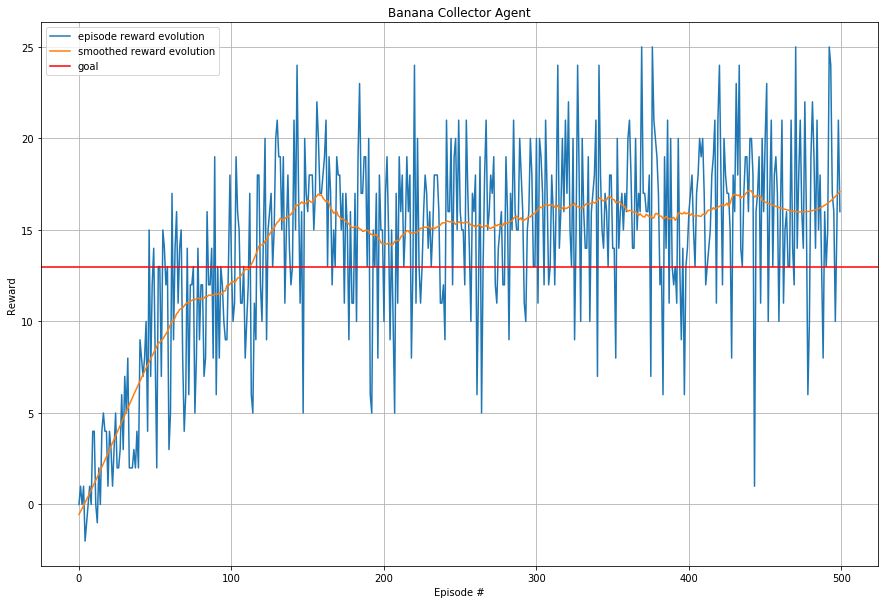

In [16]:
# Plot the reward evolution of the agent during training
agent_trainer.plot_agent_rewards(GOAL_REWARD)

In [ ]:
# Close Unity Environment
env.close()